# Exercise Sheet 2: Timing, Numpy, Plotting 
Group: LGLLK

In [23]:
import time
import numpy as np
import scipy
import scipy.spatial

In [24]:
def pydistance(x1,x2):
    return sum([(x1d-x2d)**2 for x1d,x2d in zip(x1,x2)])
def pynearest(u,X,Y,distance=pydistance):
    
    xbest = None
    ybest = None
    dbest = float('inf')
    
    for x,y in zip(X,Y):
        d = distance(u,x)
        if d < dbest:
            ybest = y
            xbest = x
            dbest = d
            
    return ybest

def pybatch(U,X,Y,nearest=pynearest,distance=pydistance):
    return [nearest(u,X,Y,distance=distance) for u in U]

In [25]:
# Our implementation
def npdistance(x1,x2):
	return np.linalg.norm(x1 - x2)

def npnearest(u,X,Y, distance=npdistance):
	#U = np.full((X.shape), u)
	u_array = np.array(u, ndmin=2)
	D = scipy.spatial.distance.cdist(u_array,X)
	#print(D.shape)
	min_idx = np.argmin(D)
	return Y[min_idx]

def npbatch(U, X, Y):
	# perform pairwise distance computation(rows of U to rows of X)
	D = scipy.spatial.distance.cdist(U, X)
	# for every u in U, find the nearest neighbor
    # i.e. the one w/ the smallest dist
	idx_list = D.argmin(axis=1)	#'axis=1' mean search by row!
	#D[np.arange(len(D)), inc.squeeze()]
	return [Y[i] for i in idx_list]

In [26]:
# Modification of the original data.py
import numpy,random

# Produces a toy dataset for testing
def toy(M,N,d):
	U = numpy.random.mtrand.RandomState(123).uniform(0,1,[M,d]) # test points
	X = numpy.random.mtrand.RandomState(456).uniform(0,1,[N,d]) # training points
	Y = numpy.random.mtrand.RandomState(789).randint(0,2,[N])   # training labels
	return U,X,Y

# A small handwritten digits dataset
def digits():
	from sklearn.datasets import load_digits
	d=load_digits()
	R = numpy.random.mtrand.RandomState(159).permutation(len(d.data))
	return d.data[R]*1, d.target[R]*1, d.images[R]*1

In [27]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 90

## Accelerating the distance computation (25 P)

In this first exercise, we would like to accelerate the function that compute pairwise distances.

* Create a new function `npdistance(x1,x2)` with the same output as `pydistance(x1,x2)`, but that computes the squared Euclidean distance using `numpy` operations.

* Print its output for the same toy example with parameters `M=20`, `N=100`, `d=50` considered before (i.e. `data.toy(20,100,50)`). Verify that in both cases (i.e. using either `npdistance` or `pydistance` in the function `pybatch`) the output remains the same.

* Create a plot similar to the one above, but where the computation time required by both methods are shown in a superposed manner. Here, we fix `M=100`, `N=100`, and we let `d` vary from `1` to `1000`, taking the list of values `[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]`.

----------------------------------------
comparison to baseline implementation
('pybatch+pynearest+pydistance', [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])
('pybatch+pynearest+npdistance', [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])
----------------------------------------


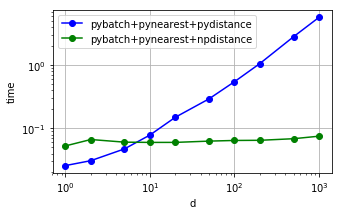

In [29]:
U,X,Y = toy(20,100,50)
print(\
"----------------------------------------\n\
comparison to baseline implementation\n\
('pybatch+pynearest+pydistance', {})\n\
('pybatch+pynearest+npdistance', {})\n\
----------------------------------------"\
      .format(pybatch(U,X,Y), pybatch(U,X,Y, distance=npdistance)))

# Values for the number of dimensions d to test
dlist = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
# Measure the computation time for each choice of number of dimensions d
tlist = []
for d in dlist:
	U,X,Y = toy(100,100,d)
	a = time.clock()
	pybatch(U,X,Y)
	b = time.clock()
	tlist += [b-a]

nptlist = []
for d in dlist:
	U,X,Y = toy(100,100,d)
	a = time.clock()
	pybatch(U,X,Y,distance=npdistance)
	b = time.clock()
	nptlist += [b-a]

# Plot the results in a graph
plt.figure(figsize=(5,3))
plt.plot(dlist, tlist,'-o', color='blue', label='pybatch+pynearest+pydistance')
plt.plot(dlist, nptlist,'-o', color='green', label='pybatch+pynearest+npdistance')
plt.xscale('log');plt.yscale('log'); 
plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)
plt.legend()

* Based on your results, explain what kind of speedup `numpy` provides, and in what regime do you expect the speedup to be the most important.

Because numpy is using vectors in stead of loops. Computation in vectors can be parallelized while loops have to  wait for the former run to finish.

## Accelerating the nearest neighbor search (25 P)

Motivated by the success of the `numpy` optimized distance computation, we would like further accelerate the code by performing nearest neighbor search directly in `numpy`.

* Create a new function `npnearest(u,X,Y)` as an alternative to the function `pynearest(u,X,Y,distance=npdistance)` that we have used in the previous exercise.

* Print its output for the same toy example as before (i.e. `data.toy(20,100,50)`). Verify that the output remains the same compared to the implementation of the previous exercise.

* Create a plot similar to the one above, where the new method is compared to the previous one. Here, we fix `M=100`, `d=100`, and we let `N` take different values `[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]`.

----------------------------------------
comparison to baseline implementation
('pybatch+pynearest+npdistance', [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])
('pybatch+npnearest'           , [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])
----------------------------------------


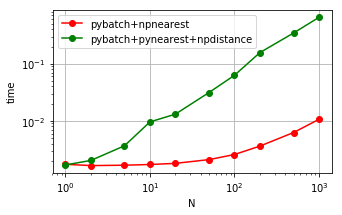

In [30]:
U,X,Y = toy(20,100,50)
print(\
"----------------------------------------\n\
comparison to baseline implementation\n\
('pybatch+pynearest+npdistance', {})\n\
('pybatch+npnearest'           , {})\n\
----------------------------------------"\
      .format(pybatch(U,X,Y, distance=npdistance), \
              pybatch(U,X,Y,nearest=npnearest, distance=npdistance)))

nptlist = []
for n in dlist:
	U,X,Y = toy(100,n,100)
	a = time.clock()
	pybatch(U,X,Y,distance=npdistance)
	b = time.clock()
	nptlist += [b-a]

npnn_tlist = []
for n in dlist:
	U,X,Y = toy(100,n,100)
	a = time.clock()
	pybatch(U,X,Y,nearest=npnearest, distance=npdistance)
	b = time.clock()
	npnn_tlist += [b-a]

# Plot the results in a graph
plt.figure(figsize=(5,3))
#plt.plot(dlist, tlist,'-o', color='blue', label='pybatch+pynearest+pydistance')
plt.plot(dlist, npnn_tlist,'-o', color='red', label='pybatch+npnearest')
plt.plot(dlist, nptlist,'-o', color='green', label='pybatch+pynearest+npdistance')
plt.xscale('log');plt.yscale('log');
plt.xlabel('N'); plt.ylabel('time'); plt.grid(True)
plt.legend()

* Based on your results, explain what kind of speedup this further optimization provides, and in what regime the speedup is the most significant.

Because scipy.spatial.distance.cdist() perform the optimized matrix operation by paralleling, it will definitely faster than traditional loop solution.

## Accelerating the processing of multiple test points (25 P)

Not yet fully happy with the performance of the algorithm, we would like to further optimize it by avoiding performing a loop on the test points, and instead, classify them all at once.

* Create a new function `npbatch(U,X,Y)` as a replacement of the implementation `pybatch(U,X,Y,nearest=npnearest)` that we have built in the previous exercise.

* Print its output for the same dataset `data.toy(20,100,50)` and verify that the output remains the same as for the previous implementation.

* Create a plot comparing the computation time of the new implementation compared to the previous one. Here, we fix `N=100`, `d=100`, and we let `M` vary from `1` to `1000` with values `[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]`.

----------------------------------------
comparison to baseline implementation
('pybatch+pynearest+npdistance', [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])
('npbatch'                     , [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0])
----------------------------------------


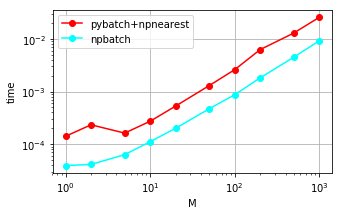

In [31]:
U,X,Y = toy(20,100,50)
print(\
"----------------------------------------\n\
comparison to baseline implementation\n\
('pybatch+pynearest+npdistance', {})\n\
('npbatch'                     , {})\n\
----------------------------------------"\
      .format(pybatch(U,X,Y,nearest=npnearest,\
                      distance=npdistance), npbatch(U,X,Y)))

npnn_tlist = []
for m in dlist:
	U,X,Y = toy(m,100,100)
	a = time.clock()
	pybatch(U,X,Y,nearest=npnearest, distance=npdistance)
	b = time.clock()
	npnn_tlist += [b-a]
      
npbatch_tlist = []
for m in dlist:
	U,X,Y = toy(m,100,100)
	a = time.clock()
	npbatch(U,X,Y)
	b = time.clock()
	npbatch_tlist += [b-a]

# Plot the results in a graph
plt.figure(figsize=(5,3))
#plt.plot(dlist, tlist,'-o', color='blue', label='pybatch+pynearest+pydistance')
plt.plot(dlist, npnn_tlist,'-o', color='red', label='pybatch+npnearest')
plt.plot(dlist, npbatch_tlist,'-o', color='cyan', label='npbatch')
plt.xscale('log');plt.yscale('log');
plt.xlabel('M'); plt.ylabel('time'); plt.grid(True)
plt.legend()

## Application to real data (25 P)

Having now implemented an efficient K-nearest neighbor classifier, we can test it on real problems with many data points and dimensions. We consider a small handwritten digits recognition dataset, that can be directly obtained from the library `scikit-learn`. This dataset consists of handwritten digits of size `8 x 8` flattened into arrays of size `64`, with class between `0` and `9`. We use a function `data.digits()` to load the data and arrange data points in some predefined order.

Using the function `imshow` of `matplotlib` to visualize the first 100 digits of the dataset.

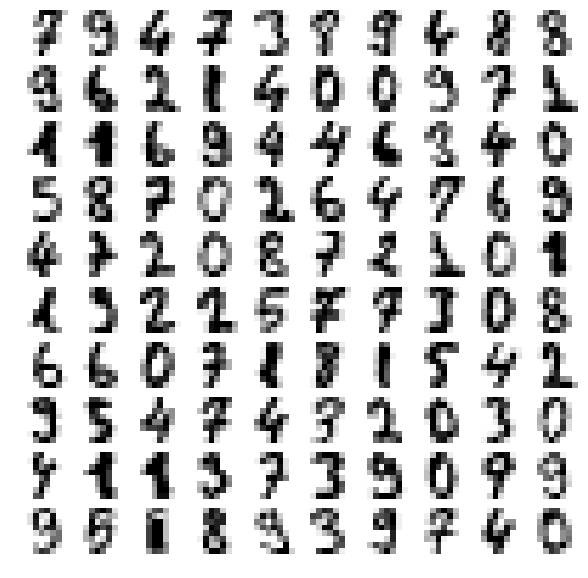

In [32]:
#exercise 4a
X, Y, I = digits()
plt.figure(figsize=(10,10))
for i in range(100):
    #plt.subplot(nrows, ncols, subplot_index<start from 1>: 
    #nrows&ncols mean the figure is split into 10 x 10 grid
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(I[i], cmap=plt.cm.gray_r, interpolation='nearest')

* Partition the data into a "training" set and "test" set. The first one contains the 1000 first digits of `X`, and the second one contains the remaining ones.
* Assume that you don't know the labels for the test data and classify the test data using your efficient nearest neighbor implementation.
* Print the predicted labels for the test set.

In [35]:
#exercise 4b
training_set = X[0:1000]
training_label = Y[0:1000]
test_set = X[1000:]
test_label_real = Y[1000:] #ground truth
test_label = npbatch(test_set, training_set, training_label)

i=0
while i < len(test_label):
    print(test_label[i:i+30])
    i=i+30

[0, 7, 3, 5, 9, 4, 7, 2, 5, 6, 1, 2, 7, 0, 0, 6, 2, 2, 4, 4, 3, 4, 0, 2, 7, 9, 1, 4, 4, 4]
[9, 4, 7, 7, 3, 1, 4, 9, 9, 3, 2, 4, 0, 4, 2, 7, 7, 5, 4, 1, 4, 5, 7, 9, 3, 7, 2, 8, 4, 9]
[8, 3, 7, 6, 5, 5, 7, 4, 3, 7, 3, 5, 0, 3, 5, 0, 0, 7, 0, 5, 9, 3, 3, 4, 7, 9, 4, 8, 6, 4]
[0, 0, 8, 2, 9, 4, 6, 4, 9, 0, 0, 3, 1, 6, 5, 1, 0, 1, 9, 2, 2, 8, 2, 6, 1, 1, 3, 8, 2, 3]
[5, 5, 8, 0, 5, 4, 8, 0, 7, 3, 6, 4, 0, 8, 9, 4, 8, 9, 9, 7, 4, 4, 6, 8, 4, 5, 2, 9, 9, 4]
[0, 5, 8, 5, 2, 2, 7, 6, 4, 8, 3, 0, 7, 6, 5, 6, 1, 0, 9, 3, 5, 6, 3, 6, 3, 3, 0, 0, 1, 4]
[1, 1, 9, 3, 8, 8, 8, 8, 2, 0, 7, 6, 5, 6, 8, 2, 0, 6, 8, 6, 0, 0, 0, 6, 9, 3, 7, 0, 1, 8]
[9, 9, 9, 1, 7, 0, 5, 5, 5, 6, 4, 1, 4, 8, 6, 6, 8, 3, 1, 0, 5, 2, 2, 6, 8, 4, 2, 1, 0, 4]
[6, 9, 9, 6, 1, 7, 2, 3, 4, 0, 5, 5, 7, 4, 8, 1, 1, 7, 8, 7, 1, 7, 5, 1, 2, 1, 3, 2, 2, 9]
[8, 7, 8, 2, 7, 2, 7, 1, 0, 9, 2, 8, 4, 2, 1, 0, 4, 2, 7, 2, 6, 9, 2, 1, 2, 5, 4, 7, 1, 6]
[3, 4, 4, 7, 0, 0, 9, 9, 9, 9, 9, 9, 1, 1, 9, 5, 7, 3, 8, 4, 8, 6, 6, 3, 1, 8, 6, 8, 4, 3]

Finally, in order to determine the accuracy of the classifier, we would like to compare the predictions with the ground truth (i.e. the true labels from the test data).

* Compute the fraction of the time on the test set where the predictions of the nearest neighbor algorithm and labels disagree. 

In [34]:
#exercise 4c
matches = test_label_real==test_label
diff = len(numpy.where(matches==False)[0])
ans = diff / len(test_label_real)
print(ans)

0.00878293601003764
